In [1]:
import os
import random
import shutil
import glob
import cv2
from glob import glob
import numpy as np
import pandas as pd


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Reshape, concatenate, Concatenate, Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard,LearningRateScheduler

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle

from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
!unzip -q /content/drive/MyDrive/Data/BrainMRI2.zip

In [3]:
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 0.0001
NUM_CLASSES = 4
SPLIT = 0.2
SEED = 42
SIZE = 256

In [4]:
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

def split_df(df):
    train_df, dummy_df = train_test_split(df, train_size= 0.8, random_state = SEED) #random_state for randomly splitting the dataset

    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5, random_state = SEED)

    return train_df, valid_df, test_df


def create_generator(df,cmd):

  datagen = ImageDataGenerator(**cmd)
  mask_data = ImageDataGenerator(**cmd)

  image_gen = datagen.flow_from_dataframe(df, x_col='images_paths', class_mode=None, color_mode='rgb', target_size=(SIZE,SIZE),
                                            batch_size=BATCH_SIZE, save_to_dir=None, save_prefix='image', seed=1)

  mask_gen = mask_data.flow_from_dataframe(df, x_col='masks_paths', class_mode=None, color_mode='grayscale', target_size=(SIZE,SIZE),
                                            batch_size=BATCH_SIZE, save_to_dir=None, save_prefix= 'mask', seed=1)

  generator = zip(image_gen,mask_gen)

  for (image,mask) in generator:
    image = image / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    yield (image, mask)


def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    for i in range(10):
        plt.subplot(5, 5, i+1)
        img_path = images[i]
        mask_path = masks[i]
        # read image and convert it to RGB scale
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # read mask
        mask = cv2.imread(mask_path)
        # sho image and mask
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [5]:
dir = '/content/Dataset2/lgg-mri-segmentation/kaggle_3m'

df = create_df(dir)
train_df, valid_df, test_df = split_df(df)

datagen_cmd = dict(
  rotation_range=0.2,
  width_shift_range=0.05,
  height_shift_range=0.05,                            
  shear_range=0.05,
  zoom_range=0.05,
  horizontal_flip=True,
  fill_mode='nearest')


print("Number of Total Dataset =", len(df))
print("Number of Train Dataset =", len(train_df))
print("Number of Validation Dataset =", len(valid_df))
print("Number of Test Dataset =", len(test_df))

Number of Total Dataset = 3929
Number of Train Dataset = 3143
Number of Validation Dataset = 393
Number of Test Dataset = 393


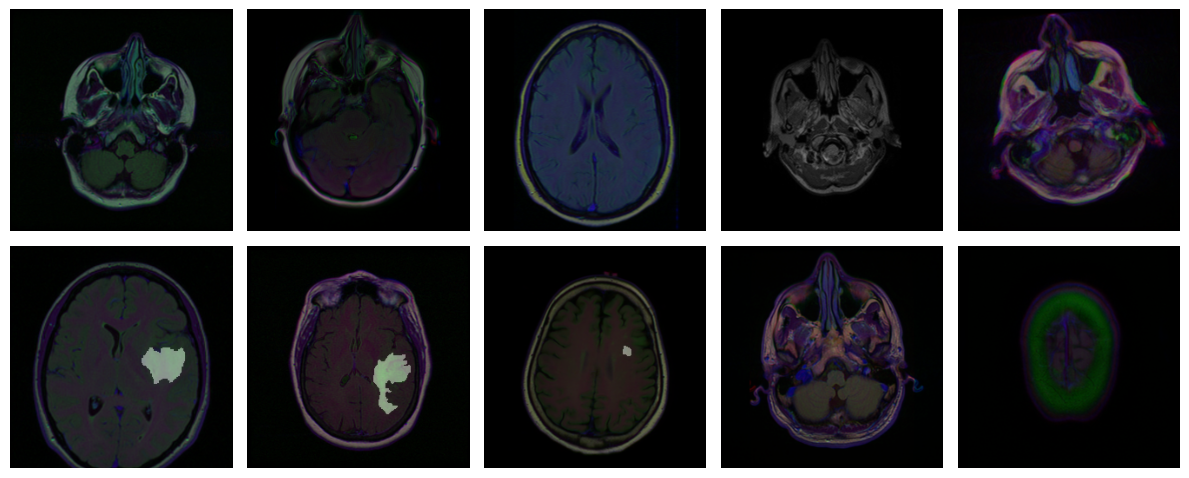

In [6]:
train_generator = create_generator(train_df, cmd = datagen_cmd)
val_generator = create_generator(valid_df, cmd = {})
test_generator = create_generator(test_df, cmd = {})

show_images(list(train_df['images_paths']), list(train_df['masks_paths']))

# DeepLab

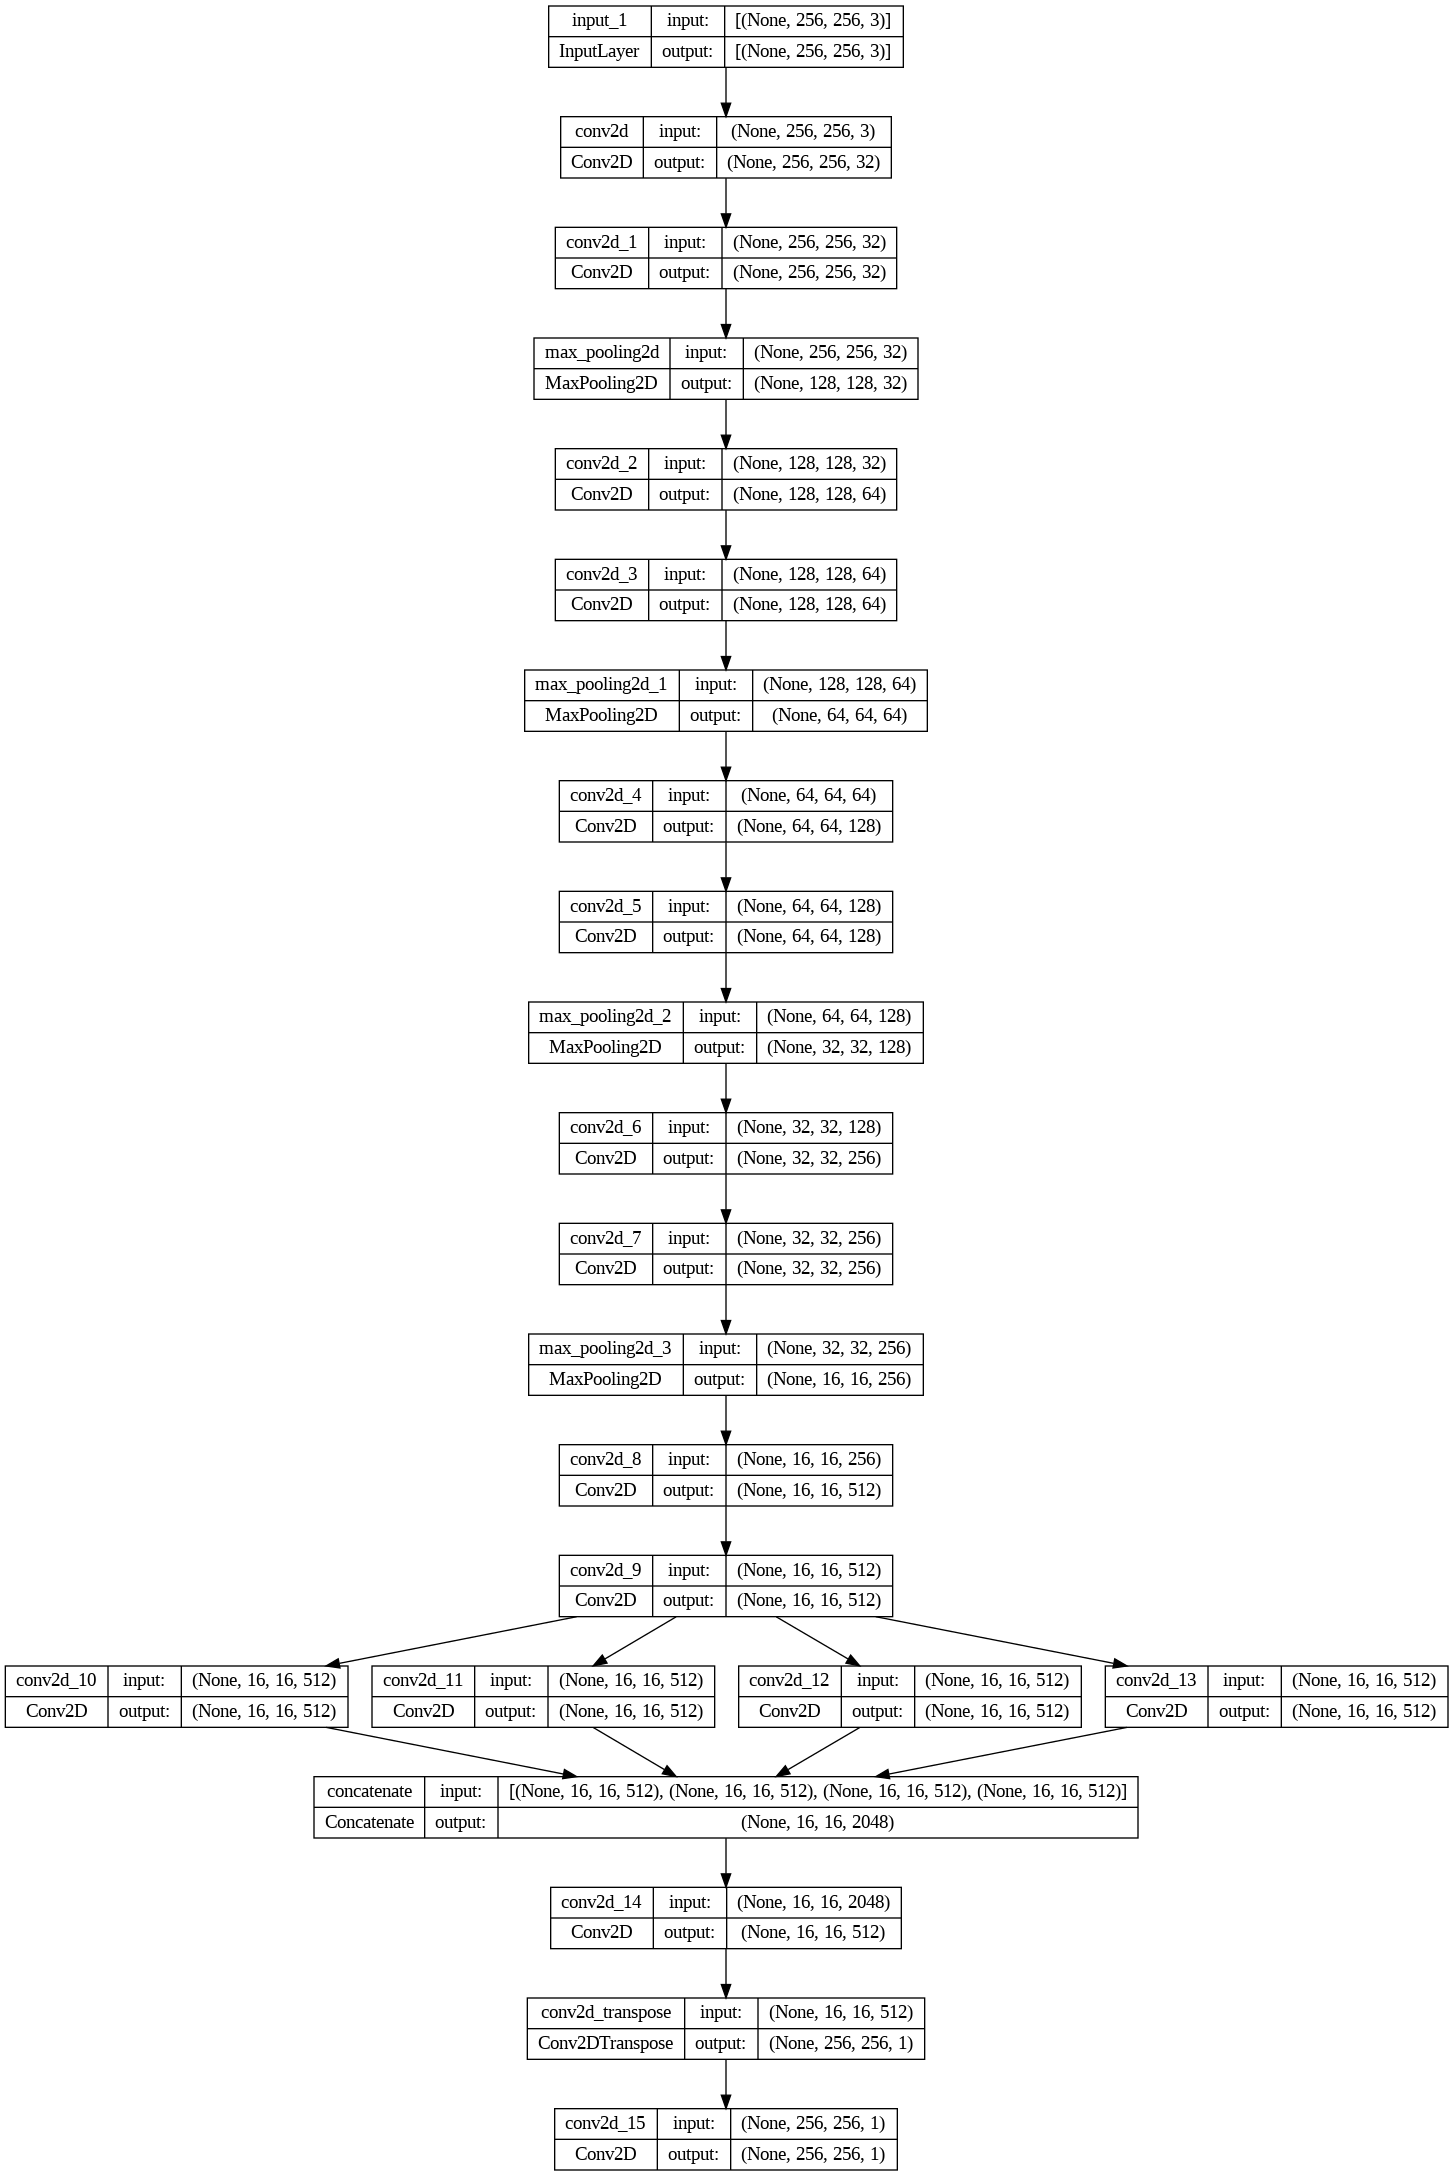

In [7]:
def deeplab_model():

    atrous_rates = [6, 12, 18, 24]
    inputs = Input((SIZE, SIZE, 3))
    
    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    
    # Atrous (dilated) Convolutions with Different Rates
    atrous_layers = []
    for rate in atrous_rates:
        atrous_layer = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=rate)(conv5)
        atrous_layers.append(atrous_layer)
        
    # Concatenated Atrous Layers
    concat = Concatenate(axis=-1)(atrous_layers)
    
    # Decoder
    conv6 = Conv2D(512, 1, activation='relu', padding='same')(concat)

    upsample = Conv2DTranspose(1, kernel_size=16, strides=16, padding='same')(conv6)
    outputs = Conv2D(1, 1, activation='sigmoid')(upsample)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    display(tf.keras.utils.plot_model(model, to_file='deeplabv1.png', show_shapes=True))
    
    return model

deepmodel = deeplab_model()

In [8]:
deepmodel.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [9]:
def scheduler(epoch, lr):
      if epoch < 5:
        return lr
      else:
        return lr * tf.math.exp(-0.1)
     

log_dir='./logs/fit'+datetime.now().strftime('%d.%m.%Y--%H-%M-%S')
model_path='/content/model_1.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy',
                             verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto',
                             save_freq='epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10,verbose=1, mode='auto')
board=TensorBoard(log_dir=log_dir,histogram_freq=1)
dec=LearningRateScheduler(scheduler)
tensorboard_callback =[checkpoint,early,board,dec]

In [10]:
hist = deepmodel.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_df) / BATCH_SIZE,
    validation_steps=len(valid_df) / BATCH_SIZE,
    callbacks=[tensorboard_callback]
)


Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/100
197/196 [==============================] - ETA: 0s - loss: 0.1437 - accuracy: 0.9871 - precision: 0.0164 - recall: 0.0041Found 393 validated image filenames.
Found 393 validated image filenames.

Epoch 1: val_accuracy improved from -inf to 0.98880, saving model to /content/model_1.h5
196/196 [==============================] - 104s 398ms/step - loss: 0.1437 - accuracy: 0.9871 - precision: 0.0164 - recall: 0.0041 - val_loss: 0.0485 - val_accuracy: 0.9888 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
197/196 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.9896 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2: val_accuracy did not improve from 0.98880
196/196 [==============================] - 67s 343ms/step - loss: 0.0441 - accuracy: 0.9896 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0488 - val_accuracy: 0.9883 - val_precisi

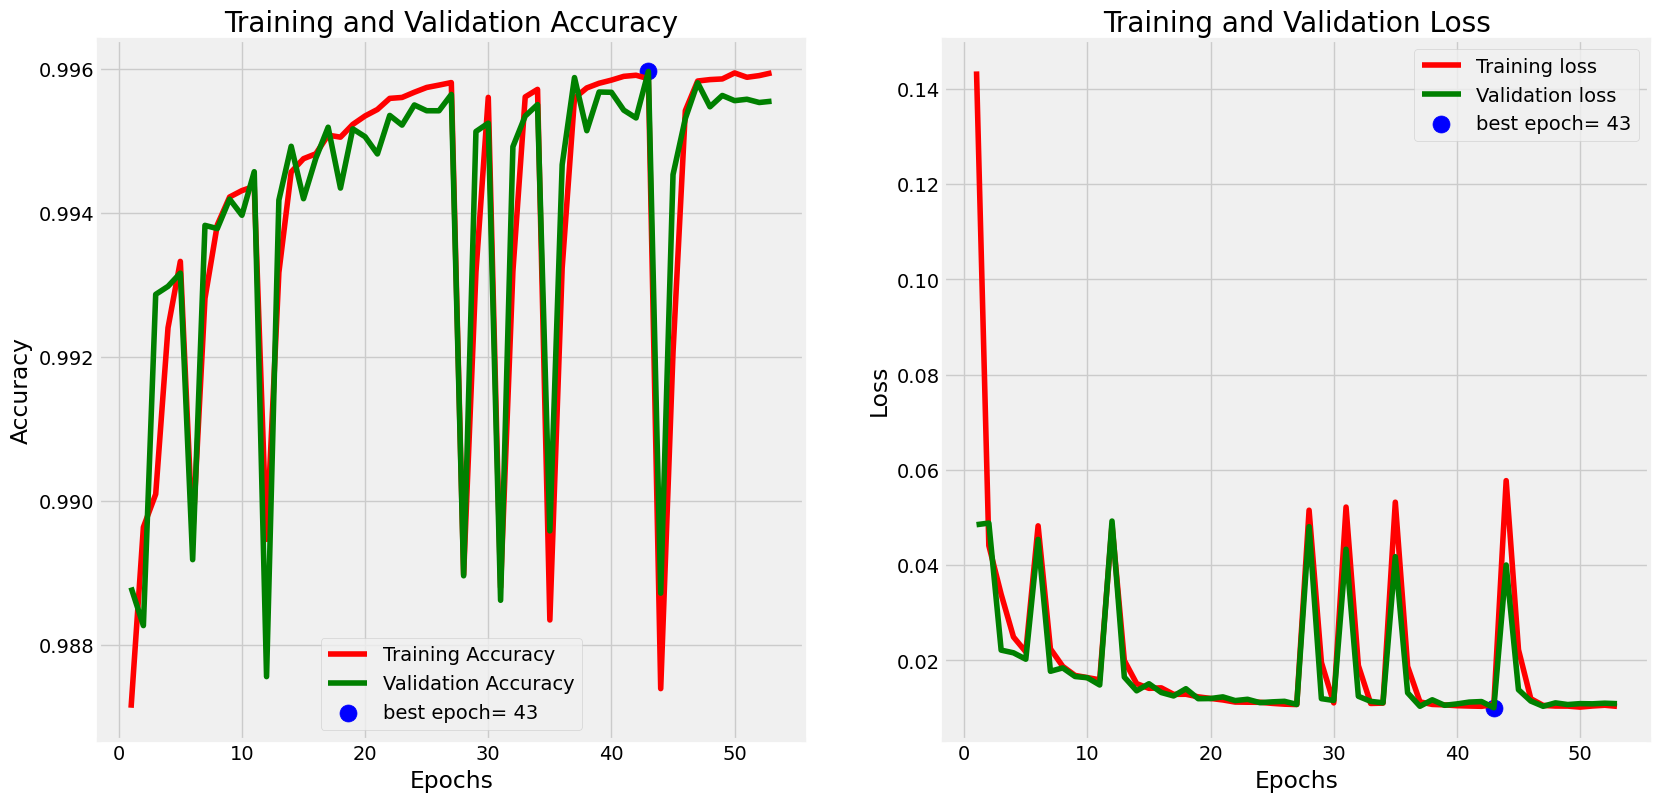

In [11]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']

    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    Epochs = [i+1 for i in range(len(tr_acc))]

    acc_label = f'best epoch= {str(index_acc + 1)}'
    loss_label = f'best epoch= {str(index_loss + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 20))
    plt.style.use('fivethirtyeight')

    # Training Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Training Loss
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()

plot_training(hist)

In [12]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = deepmodel.evaluate(train_generator, steps= test_steps, verbose= 1)
valid_score = deepmodel.evaluate(val_generator, steps= test_steps, verbose= 1)
test_score = deepmodel.evaluate(test_generator, steps= test_steps, verbose= 1)


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])

print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])


print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

131/131 [==============================] - 7s 51ms/step - loss: 0.0109 - accuracy: 0.9956 - precision: 0.8341 - recall: 0.7531
Found 393 validated image filenames.
Found 393 validated image filenames.
131/131 [==============================] - 7s 50ms/step - loss: 0.0101 - accuracy: 0.9961 - precision: 0.8125 - recall: 0.7337
Train Loss:  0.010008124634623528
Train Accuracy:  0.9959918260574341
Valid Loss:  0.010903174988925457
Valid Accuracy:  0.9955769181251526
Test Loss:  0.010053963400423527
Test Accuracy:  0.9961392283439636


# 2. UNet

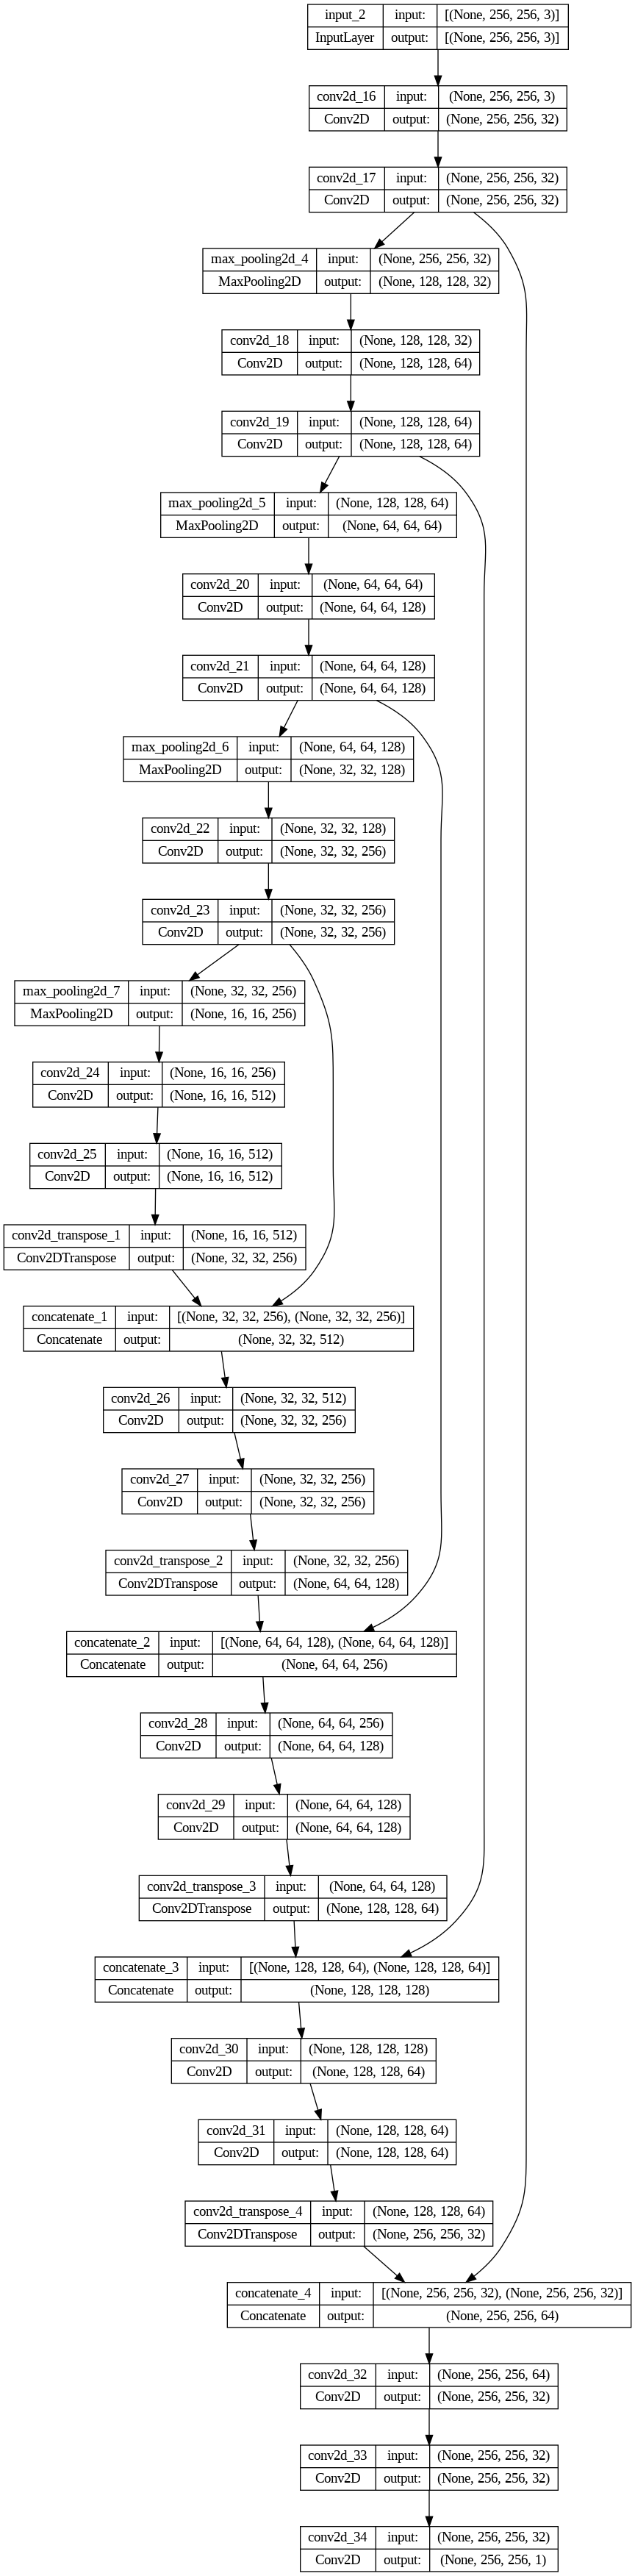

In [13]:
def unet_model():
    inputs = Input((SIZE, SIZE, 3))

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([conv4, up6])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9])
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    display(tf.keras.utils.plot_model(model, to_file='unet.png', show_shapes=True))
    
    return model

umodel = unet_model()

In [14]:
umodel.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [15]:
def scheduler(epoch, lr):
      if epoch < 5:
        return lr
      else:
        return lr * tf.math.exp(-0.1)
     

log_dir='./logs/fit'+datetime.now().strftime('%d.%m.%Y--%H-%M-%S')
model_path='/content/model_2.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy',
                             verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto',
                             save_freq='epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10,verbose=1, mode='auto')
board=TensorBoard(log_dir=log_dir,histogram_freq=1)
dec=LearningRateScheduler(scheduler)
tensorboard_callback =[checkpoint,early,board,dec]

In [16]:
hist2 = umodel.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_df) / BATCH_SIZE,
    validation_steps=len(valid_df) / BATCH_SIZE,
    callbacks=[tensorboard_callback]
)


Epoch 1/100
197/196 [==============================] - ETA: 0s - loss: 0.1318 - accuracy: 0.9868 - precision_1: 0.0110 - recall_1: 0.0031
Epoch 1: val_accuracy improved from -inf to 0.98859, saving model to /content/model_2.h5
196/196 [==============================] - 74s 325ms/step - loss: 0.1318 - accuracy: 0.9868 - precision_1: 0.0110 - recall_1: 0.0031 - val_loss: 0.0327 - val_accuracy: 0.9886 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
197/196 [==============================] - ETA: 0s - loss: 0.0295 - accuracy: 0.9896 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 2: val_accuracy improved from 0.98859 to 0.98879, saving model to /content/model_2.h5
196/196 [==============================] - 62s 318ms/step - loss: 0.0295 - accuracy: 0.9896 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 0.0263 - val_accuracy: 0.9888 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/100
197/196 [========

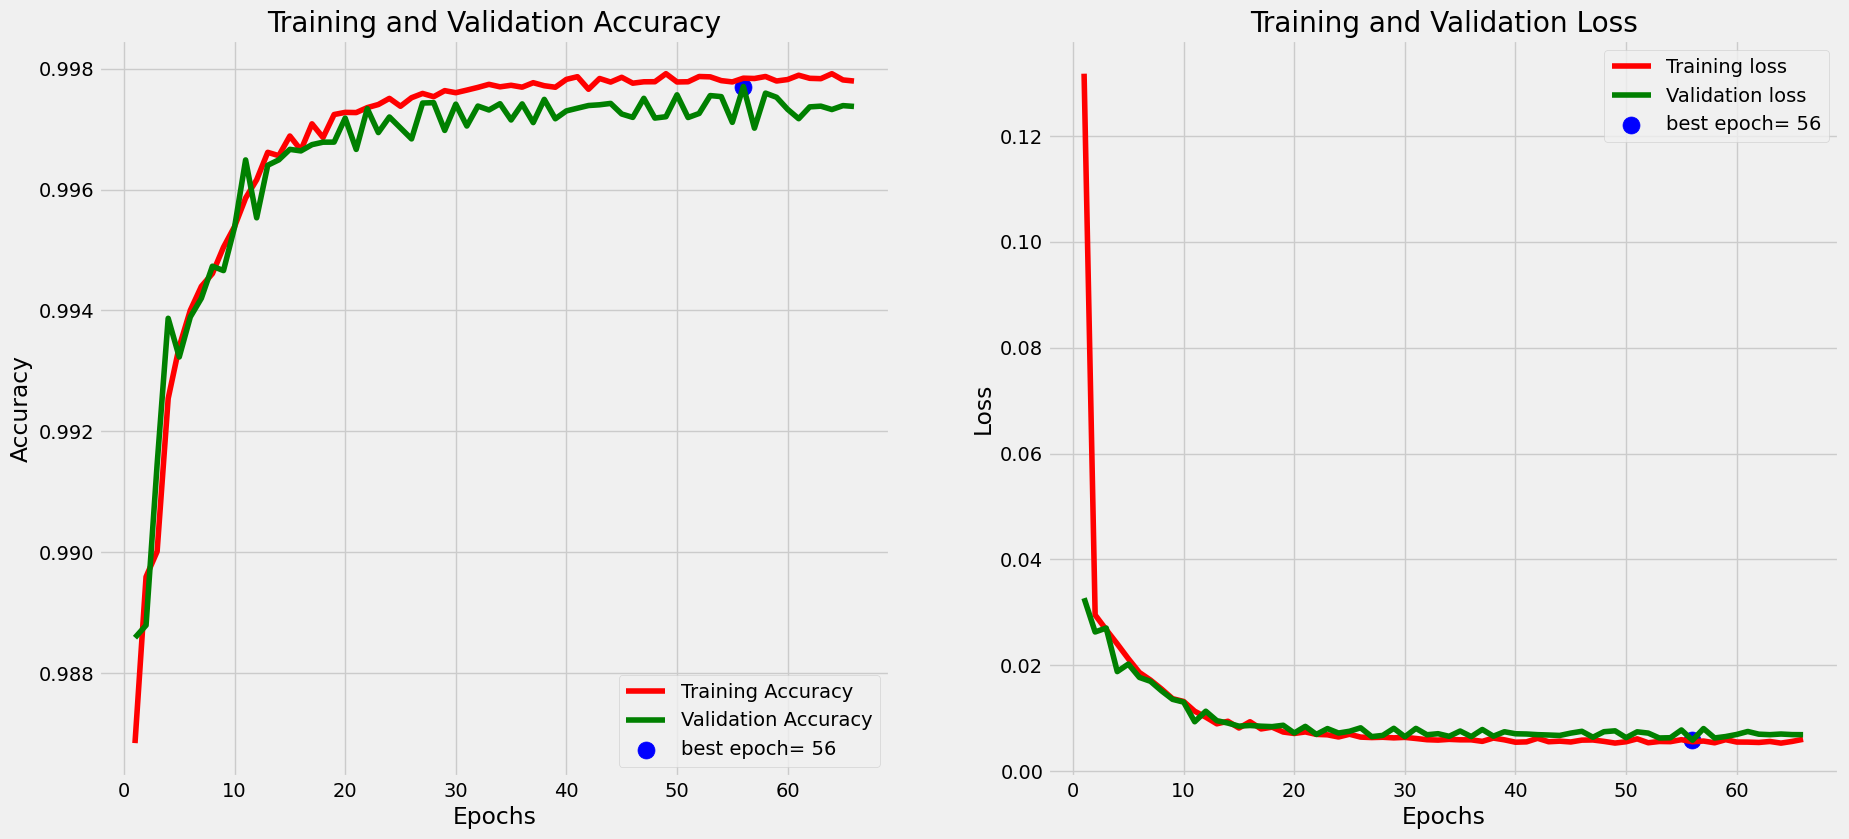

In [17]:
plot_training(hist2)

In [18]:
train2_score = umodel.evaluate(train_generator, steps= test_steps, verbose= 1)
valid2_score = umodel.evaluate(val_generator, steps= test_steps, verbose= 1)
test2_score = umodel.evaluate(test_generator, steps= test_steps, verbose= 1)


print("Train Loss: ", train2_score[0])
print("Train Accuracy: ", train2_score[1])

print("Valid Loss: ", valid2_score[0])
print("Valid Accuracy: ", valid2_score[1])


print("Test Loss: ", test2_score[0])
print("Test Accuracy: ", test2_score[1])

131/131 [==============================] - 6s 46ms/step - loss: 0.0063 - accuracy: 0.9976 - precision_1: 0.8669 - recall_1: 0.8660
Train Loss:  0.005221044644713402
Train Accuracy:  0.9979084730148315
Valid Loss:  0.006780768744647503
Valid Accuracy:  0.9974156022071838
Test Loss:  0.006338824983686209
Test Accuracy:  0.9975910782814026


1/1 [==============================] - 0s 22ms/step


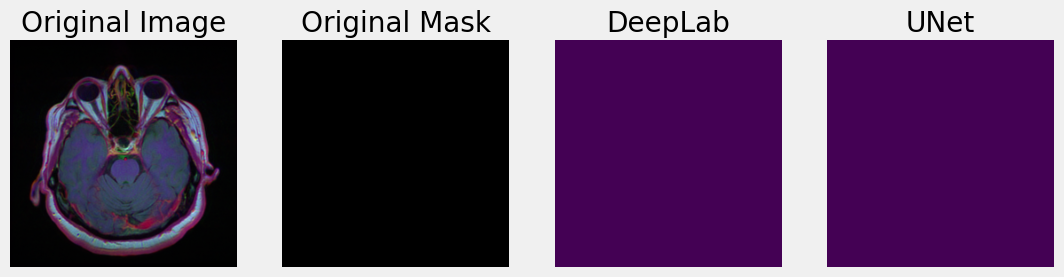

1/1 [==============================] - 0s 21ms/step


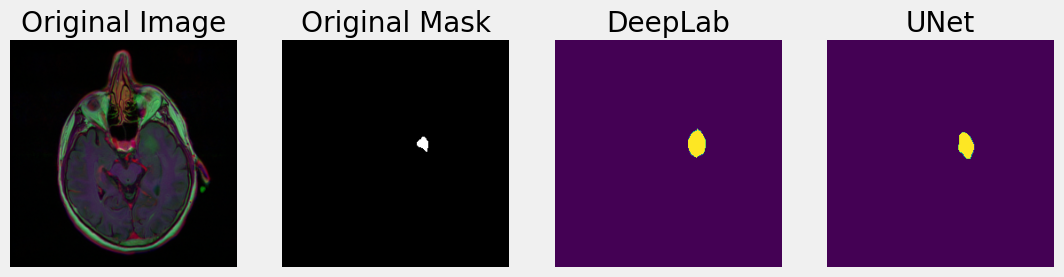

1/1 [==============================] - 0s 19ms/step


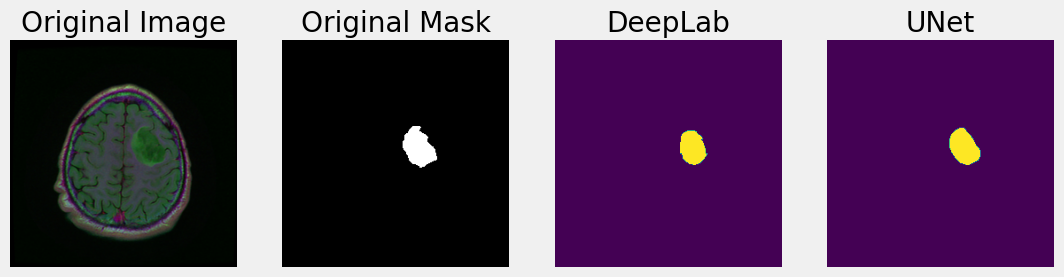

1/1 [==============================] - 0s 20ms/step


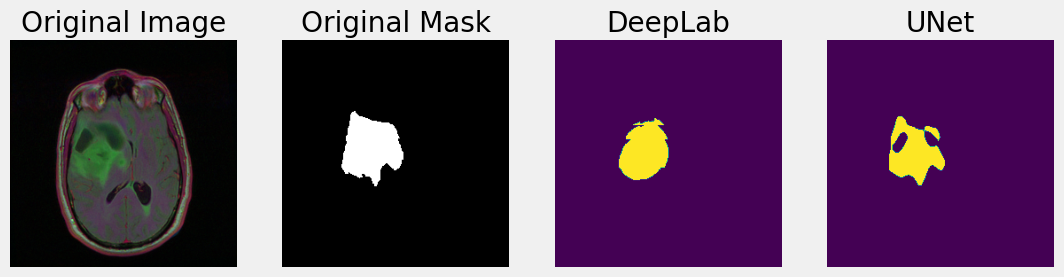

1/1 [==============================] - 0s 21ms/step


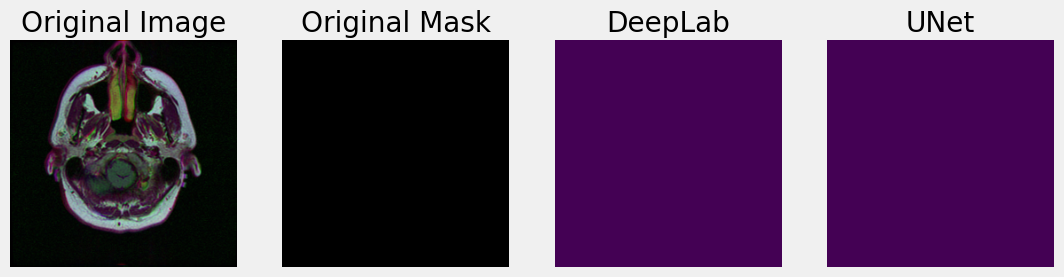

1/1 [==============================] - 0s 22ms/step


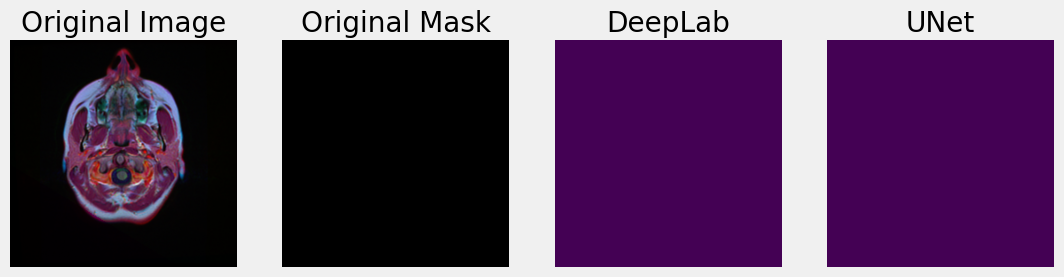

1/1 [==============================] - 0s 21ms/step


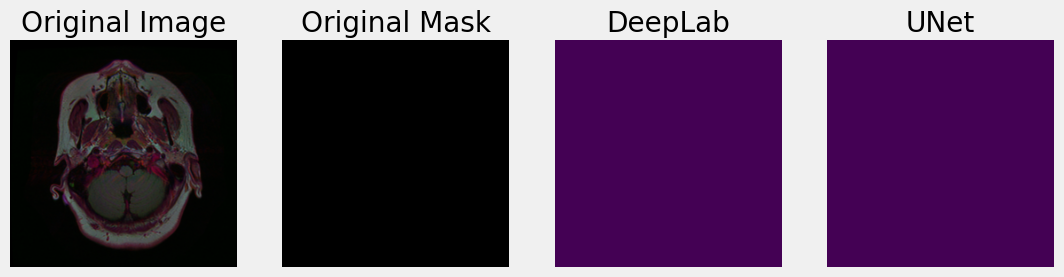

1/1 [==============================] - 0s 24ms/step


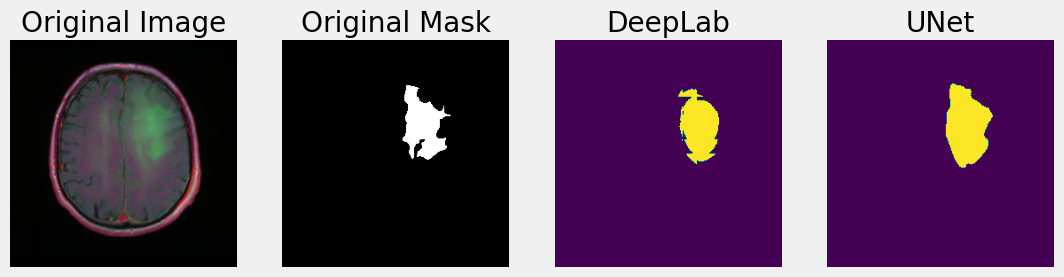

1/1 [==============================] - 0s 22ms/step


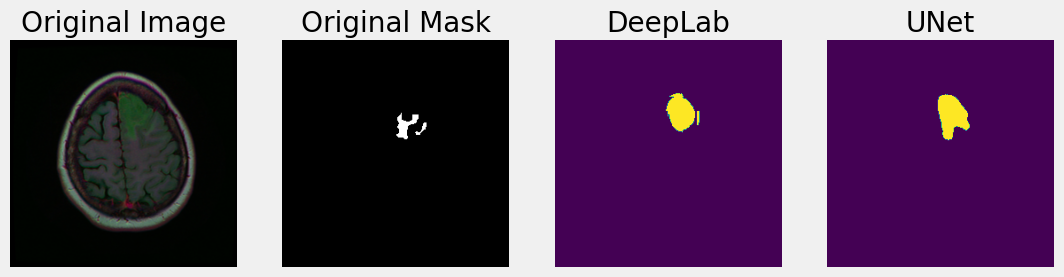

1/1 [==============================] - 0s 23ms/step


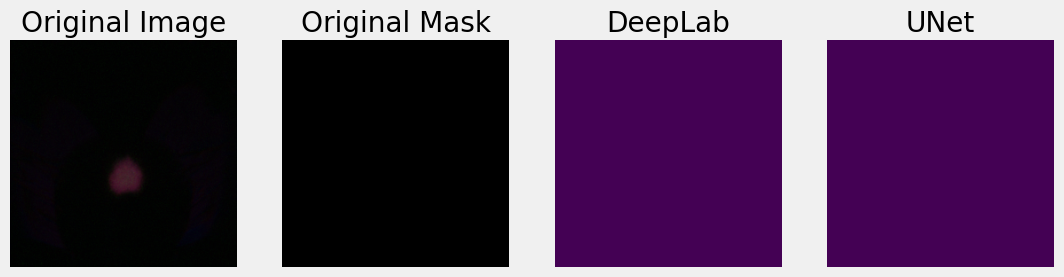

1/1 [==============================] - 0s 27ms/step


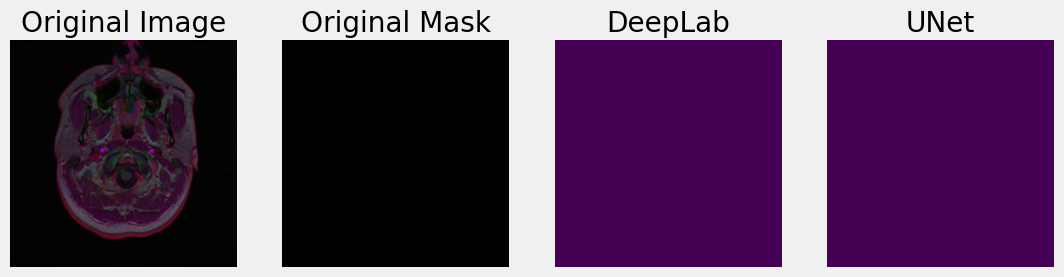

1/1 [==============================] - 0s 22ms/step


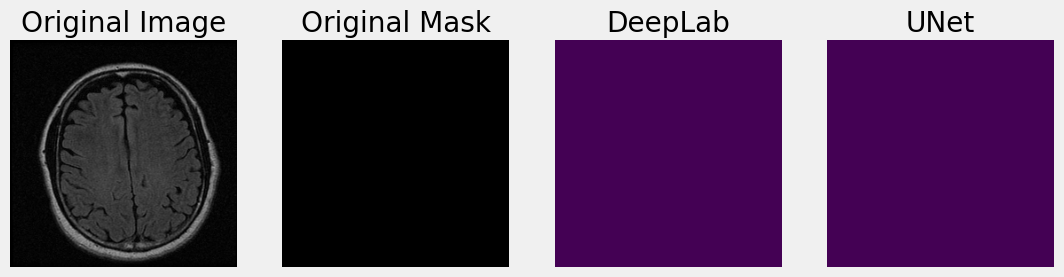

1/1 [==============================] - 0s 23ms/step


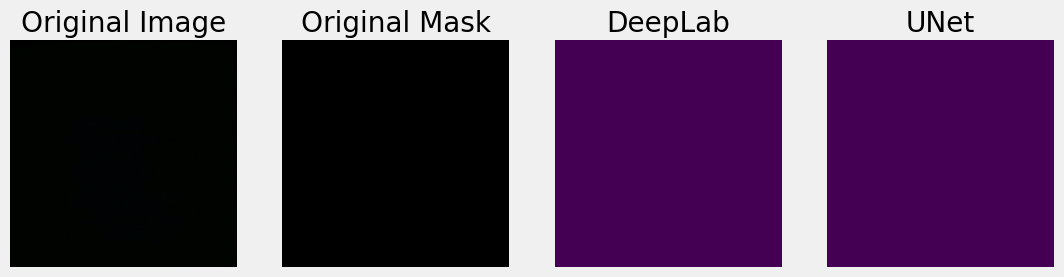

1/1 [==============================] - 0s 21ms/step


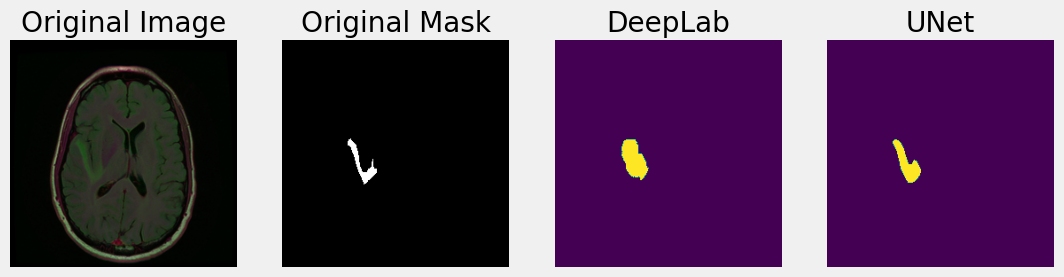

1/1 [==============================] - 0s 21ms/step


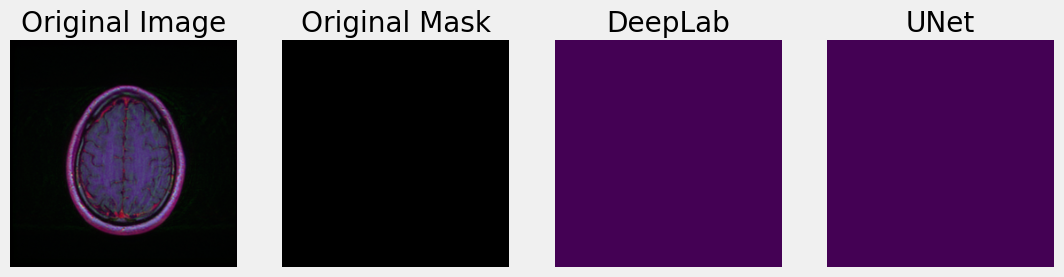

1/1 [==============================] - 0s 21ms/step


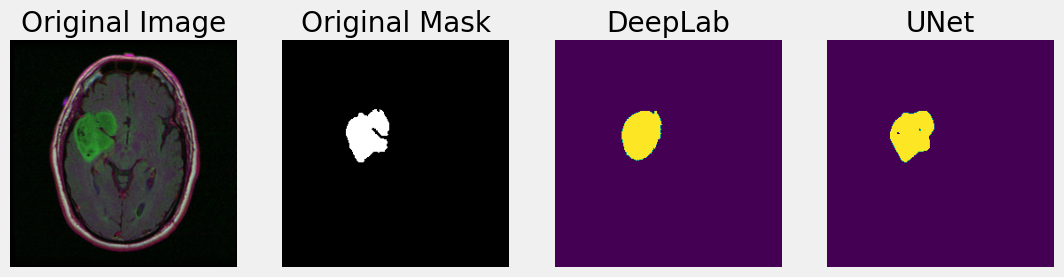

1/1 [==============================] - 0s 22ms/step


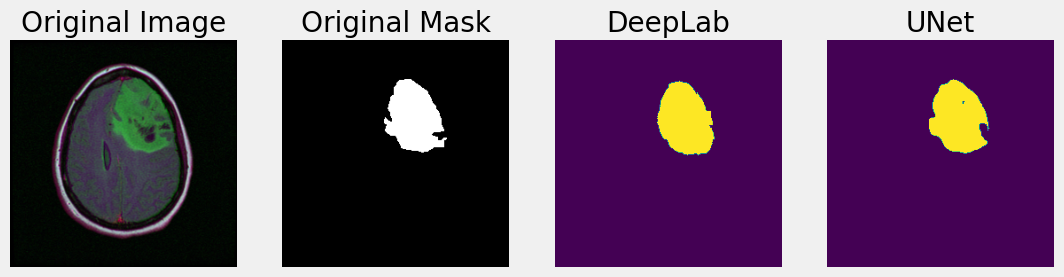

1/1 [==============================] - 0s 21ms/step


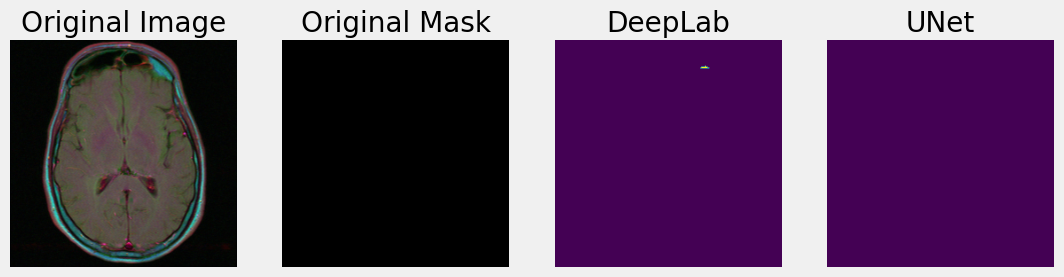

1/1 [==============================] - 0s 20ms/step


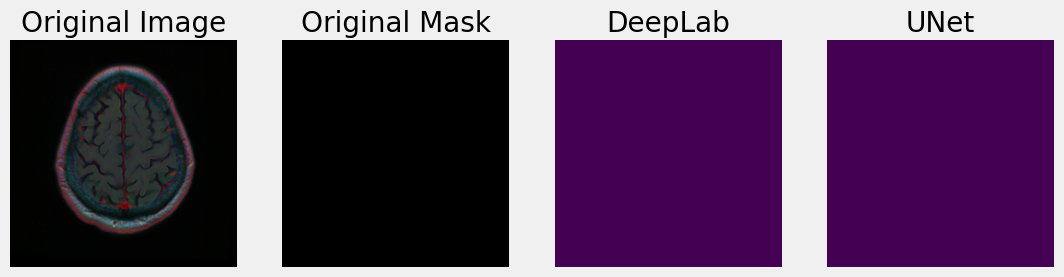

1/1 [==============================] - 0s 21ms/step


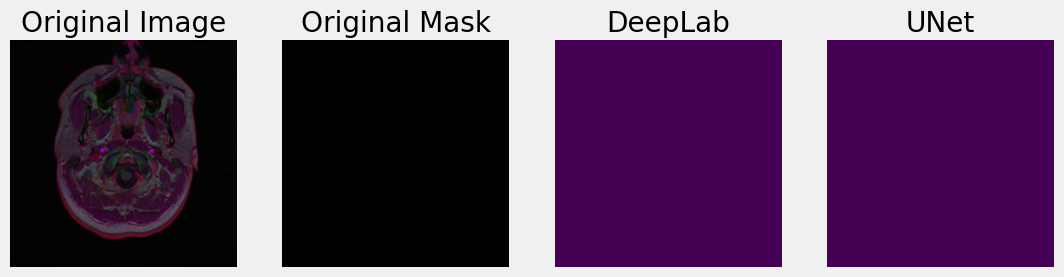

1/1 [==============================] - 0s 22ms/step


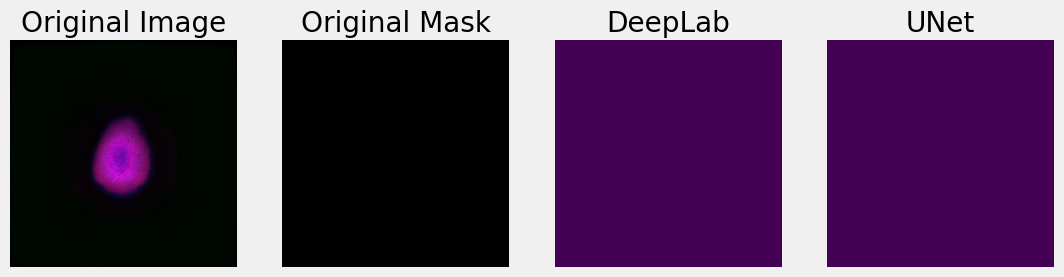

1/1 [==============================] - 0s 20ms/step


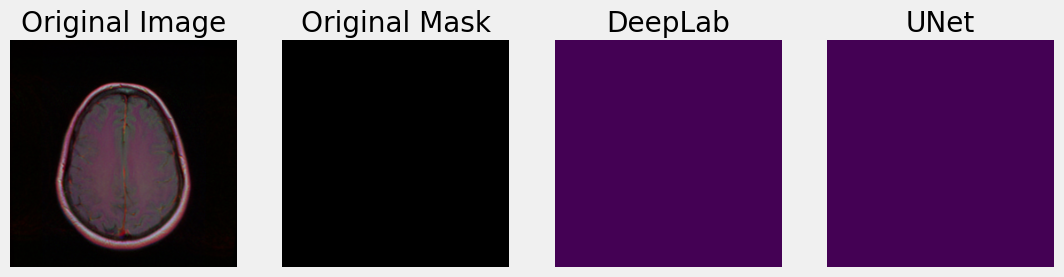

1/1 [==============================] - 0s 21ms/step


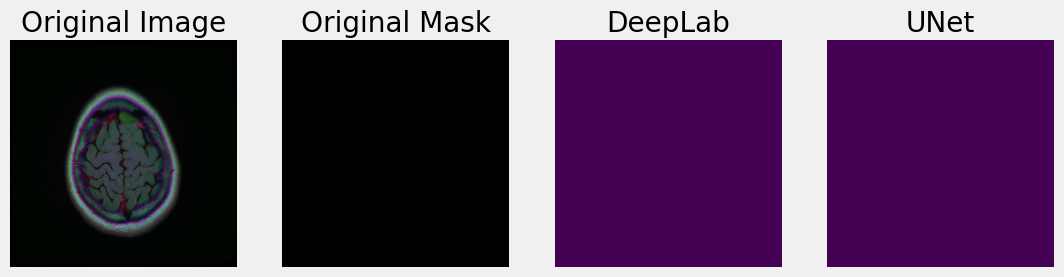

1/1 [==============================] - 0s 23ms/step


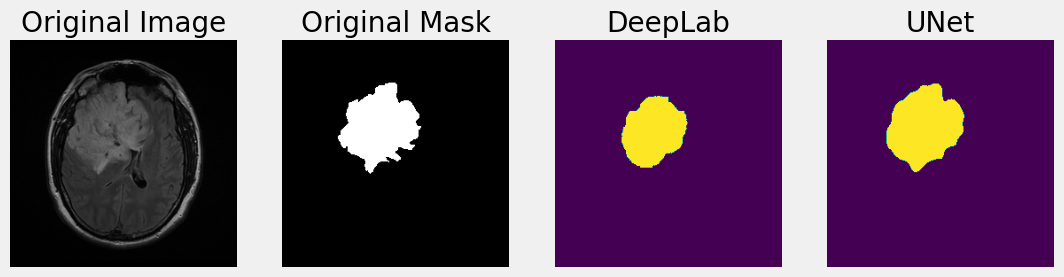

1/1 [==============================] - 0s 26ms/step


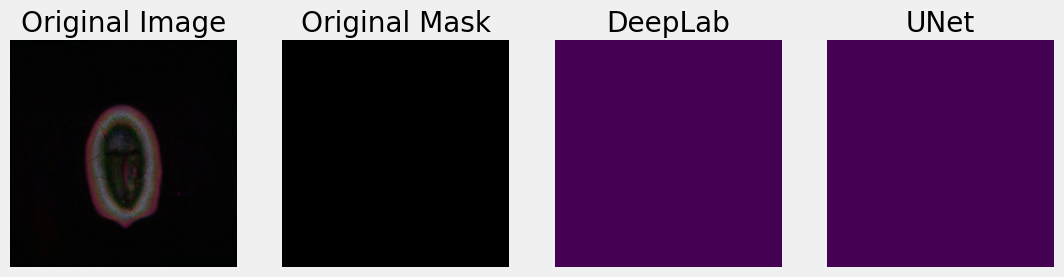

In [20]:
for _ in range(25):
    index = np.random.randint(1, len(test_df.index))
    img = cv2.imread(test_df['images_paths'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    deep_img = deepmodel.predict(img)
    unet_img = umodel.predict(img)

    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 4, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(np.squeeze(cv2.imread(test_df['masks_paths'].iloc[index])))
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 4, 3)
    plt.imshow(np.squeeze(deep_img) > 0.5 )
    plt.title('DeepLab')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(np.squeeze(unet_img) > 0.5 )
    plt.title('UNet')
    plt.axis('off')
    
    plt.show()